Apply different portfolio performance measures to evaluate and compare portfolio allocation strategies. For this purpose, we introduce a direct way to estimate optimal portfolio weights for large-scale cross-sectional applications. 
- **Parametrize the optimal portfolio weights as a function of stock characteristics instead of estimating the stock’s expected return, variance, and covariances with other stocks in a prior step.**

- **Choose weights that as a function of characteristics that maximize the expected utility of the investor**

In [188]:
import pandas as pd
import numpy as np
import sqlite3
import statsmodels.formula.api as smf

from itertools import product, starmap
from scipy.optimize import minimize

In [189]:
your_path = input("Please specify the local path where you stored the db FamaFrench.sqlite: ") 

database = sqlite3.connect(database= f"{your_path}\FamaFrench.sqlite") 

crsp_monthly = (pd.read_sql_query(
    sql=("SELECT permno, month, ret_excess, mktcap, mktcap_lag "
         "FROM crsp_monthly"),
    con=database,
    parse_dates={"month"})
  .dropna()
)

Please specify the local path where you stored the db FamaFrench.sqlite: C:\Users\rober\Downloads


To evaluate the performance of portfolios, we further use monthly market returns as a benchmark to compute CAPM alphas.

In [190]:
factors_ff_monthly = pd.read_sql_query(
  sql="SELECT month, mkt_excess FROM factors_ff3_monthly",
  con=database,
  parse_dates={"month"}
)

In [4]:
crsp_monthly.iloc[0:30]

,permno,month,ret_excess,mktcap,mktcap_lag
0,10089,1998-04-01,0.035700,32.638125,31.378125
1,10089,1998-05-01,-0.042462,31.382812,32.638125
2,10089,1998-06-01,-0.284100,22.595625,31.382812
3,10089,1998-07-01,0.005259,23.108000,22.595625
4,10089,1998-08-01,-0.545584,10.600000,23.108000
5,10089,1998-09-01,0.655400,17.596000,10.600000
6,10089,1998-10-01,-0.352598,11.697750,17.596000
7,10089,1998-11-01,0.033937,12.131000,11.697750
8,10089,1998-12-01,-0.128800,10.614625,12.131000
9,10089,1999-01-01,0.139357,12.131000,10.614625


Next, we retrieve some stock characteristics that **have been shown to have an effect on the expected returns or expected variances (or even higher moments) of the return distribution.** In particular, we record the **lagged one-year return momentum (momentum_lag)**, defined as the compounded return between months t-13 and t-2
 and 
 for each firm. In finance, momentum is the empirically observed tendency for rising asset prices to rise further and falling prices to keep falling (Jegadeesh and Titman 1993). **The second characteristic is the firm’s market equity (size_lag)**, defined as **the log of the price per share** x **the number of shares outstanding** (Banz 1981). To construct the correct lagged values, we use the approach introduced in WRDS, CRSP, and Compustat.

In [191]:
#momentum: (empirically observed) tendency for (rising) asset prices to rise further and falling prices to keep falling
#one year momentum lag: compounded return between months t-13 and t-2 for each firm 

crsp_monthly_lags = (crsp_monthly
  .assign(month=lambda x: x["month"]+pd.DateOffset(months=13)) #DateOffset moves the values for the variables in get by the specified months
  .get(["permno", "month", "mktcap"])
)


In [6]:
crsp_monthly_lags.iloc[0:10]

,permno,month,mktcap
0,10089,1999-05-01,32.638125
1,10089,1999-06-01,31.382812
2,10089,1999-07-01,22.595625
3,10089,1999-08-01,23.108000
4,10089,1999-09-01,10.600000
5,10089,1999-10-01,17.596000
6,10089,1999-11-01,11.697750
7,10089,1999-12-01,12.131000
8,10089,2000-01-01,10.614625
9,10089,2000-02-01,12.131000


In [192]:
crsp_monthly = (crsp_monthly
  .merge(crsp_monthly_lags, 
         how="inner", on=["permno", "month"], suffixes=["", "_13"])
)


In [8]:
crsp_monthly.iloc[0:30]

,permno,month,ret_excess,mktcap,mktcap_lag,mktcap_13
0,10089,1998-04-01,0.035700,32.638125,31.378125,19.196375
1,10089,1998-05-01,-0.042462,31.382812,32.638125,20.034000
2,10089,1998-06-01,-0.284100,22.595625,31.382812,20.868750
3,10089,1998-07-01,0.005259,23.108000,22.595625,22.538250
4,10089,1998-08-01,-0.545584,10.600000,23.108000,23.822437
5,10089,1998-09-01,0.655400,17.596000,10.600000,24.240375
6,10089,1998-10-01,-0.352598,11.697750,17.596000,33.435000
7,10089,1998-11-01,0.033937,12.131000,11.697750,30.114000
8,10089,1998-12-01,-0.128800,10.614625,12.131000,24.258500
9,10089,1999-01-01,0.139357,12.131000,10.614625,25.931500


In [193]:
data_portfolios = (crsp_monthly
  .assign(
    momentum_lag=lambda x: x["mktcap_lag"]/x["mktcap_13"], #why? Sarebbe: mktcap t-1/mktcap t-13
    size_lag=lambda x: np.log(x["mktcap_lag"])
  )
  .dropna(subset=["momentum_lag", "size_lag"])
)

In [10]:
data_portfolios #.iloc[0:14]

,permno,month,ret_excess,mktcap,mktcap_lag,mktcap_13,momentum_lag,size_lag
0,10089,1998-04-01,0.035700,32.638125,31.378125,19.196375,1.634586,3.446111
1,10089,1998-05-01,-0.042462,31.382812,32.638125,20.034000,1.629137,3.485481
2,10089,1998-06-01,-0.284100,22.595625,31.382812,20.868750,1.503819,3.446260
3,10089,1998-07-01,0.005259,23.108000,22.595625,22.538250,1.002546,3.117756
4,10089,1998-08-01,-0.545584,10.600000,23.108000,23.822437,0.970010,3.140179
...,...,...,...,...,...,...,...,...
2978981,10107,2016-11-01,0.012083,468542.651260,465899.031920,420483.740320,1.108007,13.051724
2978982,10107,2016-12-01,0.030898,480342.200000,468542.651260,434143.071550,1.079236,13.057382
2978983,10107,2017-01-01,0.039993,499584.814500,480342.200000,439679.000000,1.092484,13.082254
2978984,10107,2017-02-01,-0.004731,494407.369400,499584.814500,435723.502270,1.146564,13.121533


## Parametric portfolio policies

Basic idea: choose the portfolio weights $w_{i,t}$ maximising the expected utility of the portfolio return
- it is basically active portfolio management relative to a portfolio benchmark (the weights of the stock in the benchmark portfolio)

- The deviations are given by the stock characteristics taken into consideration, weighted by the estimated theta
- Coefficient in the theta vector are constant across assets and over time

In [194]:
# compute relative mkt cap + standardization
data_portfolios = (data_portfolios
  .groupby("month")
  .apply(lambda x: x.assign(
      relative_mktcap=x["mktcap_lag"]/x["mktcap_lag"].sum()
    )
  )
  .reset_index(drop=True)
  .set_index("month")
  .groupby(level="month")
  .transform(
    lambda x: (x-x.mean())/x.std() if x.name.endswith("lag") else x
  )
  .reset_index()
  .drop(["mktcap_lag"], axis=1)
)

C:\Users\rober\AppData\Local\Temp/ipykernel_30776/2602146392.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [195]:
#cross check that it was correctly standardized (CORRECT)

print(np.mean(data_portfolios["size_lag"]))
print(np.mean(data_portfolios["momentum_lag"]))
print(np.std(data_portfolios["size_lag"]))
print(np.std(data_portfolios["momentum_lag"]))

1.0752405861613755e-17
1.9463094904784437e-18
0.9998754532230544
0.999875453223054


In [56]:
data_portfolios

,month,permno,ret_excess,mktcap,mktcap_13,momentum_lag,size_lag,relative_mktcap
0,1961-03-01,10057,-0.108838,26.125000,2.650000e+01,-0.117690,-0.674513,9.135427e-05
1,1961-03-01,10006,0.084849,77.745000,7.143175e+01,-0.297165,-0.088914,2.234120e-04
2,1961-03-01,10030,0.020159,72.198125,8.140300e+01,-0.511039,-0.088406,2.235853e-04
3,1961-03-01,10137,-0.016546,435.972000,3.332340e+02,0.295825,1.110140,1.394230e-03
4,1961-03-01,10014,0.081333,12.207000,1.227937e+01,-0.444047,-1.299168,3.519248e-05
...,...,...,...,...,...,...,...,...
2978981,2022-12-01,93368,-0.095435,129.376960,1.490940e+02,0.235725,-0.642647,3.533009e-06
2978982,2022-12-01,93426,-0.050626,485.096150,4.326610e+02,0.639226,-0.109707,1.266500e-05
2978983,2022-12-01,93339,-0.217793,20.032320,3.628574e+01,-0.279783,-1.381809,6.013607e-07
2978984,2022-12-01,93423,-0.038169,1933.400250,3.144398e+03,-0.332387,0.462057,4.982617e-05


### Computing portfolio weights
Estimate $\theta$. $\theta$ contains only two elements in our application -the ***relative deviation from the benchmark due to size*** and ***momentum***.
To get a feeling of how this works: start with an arbitrary specification $\theta_0$, next choose $\theta$ optimally to maximize the objective function.


In [196]:
lag_columns = [i for i in data_portfolios.columns if "lag" in i] #very flexible 
n_parameters = len(lag_columns) #theta length 
theta = pd.DataFrame({"theta_0": [1.5]*n_parameters}, index=lag_columns) #create a new df with the vector theta 

In [197]:
theta

,theta_0
momentum_lag,1.5
size_lag,1.5


In [64]:
data_portfolios[theta.index]  #theta'* firm charateristics (matrix multiplication)

,momentum_lag,size_lag
0,-0.117690,-0.674513
1,-0.297165,-0.088914
2,-0.511039,-0.088406
3,0.295825,1.110140
4,-0.444047,-1.299168
...,...,...
2978981,0.235725,-0.642647
2978982,0.639226,-0.109707
2978983,-0.279783,-1.381809
2978984,-0.332387,0.462057


In [198]:
data_portfolios[theta.index] @ theta  #averaging on the asset universe 
#however, deviation seem infinitesimal (because the values were already standardised!)

,theta_0
0,-1.188305
1,-0.579117
2,-0.899168
3,2.108947
4,-2.614822
...,...
2978981,-0.610383
2978982,0.794279
2978983,-2.492388
2978984,0.194506


Brief explamantion of the compute_portfolio_weights formula below: 
- for any lag columns and theta (OK)
- define what is the characteristic_tilt: i.e. what characterizes the portfolio weighting function (w_b+1/N_theta*x)

In [199]:
def compute_portfolio_weights(theta, 
                              data,
                              value_weighting=True,
                              allow_short_selling=True):
    """Compute portfolio weights for different strategies."""
    
    lag_columns = [i for i in data.columns if "lag" in i]
    theta = pd.DataFrame(theta, index=lag_columns)

    data = (data
      .groupby("month")
      .apply(lambda x: x.assign(
          characteristic_tilt=x[theta.index] @ theta / x.shape[0] #@ is matrix multiplication; shape is number of rows [0] and columns[1]
        ) #x.shape[0] is the averaging over the assets universe 
      )
      .reset_index(drop=True)
      .assign(
        weight_benchmark=lambda x: 
          x["relative_mktcap"] if value_weighting else 1/x.shape[0],
        weight_tilt=lambda x: 
          x["weight_benchmark"] + x["characteristic_tilt"] #our weighting functiion
      )
      .drop(columns=["characteristic_tilt"])
    )

    if not allow_short_selling:
        data = (data
          .assign(weight_tilt=lambda x: np.maximum(0, x["weight_tilt"])) #assigns zero to weights that would be negative
        )

    data = (data
      .groupby("month")
      .apply(lambda x: x.assign(
        weight_tilt=lambda x: x["weight_tilt"]/x["weight_tilt"].sum())) #to make sure they sum up to one?
      .reset_index(drop=True)
    )

    return data

Direct application of the formula above (yes short selling), but theta is not estimated, given exogeneously

In [200]:
#portfolio weights for the arbitrary vector theta_0 (negative portfolio weights allowed)
weights_crsp = compute_portfolio_weights(
  theta,
  data_portfolios,
  value_weighting=True,
  allow_short_selling=True
)

C:\Users\rober\AppData\Local\Temp/ipykernel_30776/1466773209.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\rober\AppData\Local\Temp/ipykernel_30776/1466773209.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [37]:
weights_crsp #but the weights are very close to the benchmark!!!

,month,permno,ret_excess,mktcap,mktcap_13,momentum_lag,size_lag,relative_mktcap,weight_benchmark,weight_tilt
0,1961-03-01,10057,-0.108838,26.125000,2.650000e+01,-0.117690,-0.674513,9.135427e-05,9.135427e-05,-0.001060
1,1961-03-01,10006,0.084849,77.745000,7.143175e+01,-0.297165,-0.088914,2.234120e-04,2.234120e-04,-0.000338
2,1961-03-01,10030,0.020159,72.198125,8.140300e+01,-0.511039,-0.088406,2.235853e-04,2.235853e-04,-0.000648
3,1961-03-01,10137,-0.016546,435.972000,3.332340e+02,0.295825,1.110140,1.394230e-03,1.394230e-03,0.003438
4,1961-03-01,10014,0.081333,12.207000,1.227937e+01,-0.444047,-1.299168,3.519248e-05,3.519248e-05,-0.002499
...,...,...,...,...,...,...,...,...,...,...
2978981,2022-12-01,93368,-0.095435,129.376960,1.490940e+02,0.235725,-0.642647,3.533009e-06,3.533009e-06,-0.000151
2978982,2022-12-01,93426,-0.050626,485.096150,4.326610e+02,0.639226,-0.109707,1.266500e-05,1.266500e-05,0.000214
2978983,2022-12-01,93339,-0.217793,20.032320,3.628574e+01,-0.279783,-1.381809,6.013607e-07,6.013607e-07,-0.000632
2978984,2022-12-01,93423,-0.038169,1933.400250,3.144398e+03,-0.332387,0.462057,4.982617e-05,4.982617e-05,0.000099


### Portfolio performance

To evaluate the performance of an allocation strategy, different approaches are available. One of the most common: evaluate the utility function of the investor, usually of the functional form: $u_\gamma(r)= \frac{(1+r)^(1-\gamma)}{(1-\gamma)}$

In [201]:
def power_utility(r, gamma=5):
    """Calculate power utility for given risk aversion."""
    
    utility = ((1+r)**(1-gamma))/(1-gamma)
    
    return utility

Function to evaluate a portfolio: defined below


In [202]:
def evaluate_portfolio(weights_data, #dataframe after the weights are assigned 
                       full_evaluation=True,
                       capm_evaluation=True,
                       length_year=12):
    """Calculate portfolio evaluation measures."""
    evaluation = (weights_data #performs the portfolio returns both with weight_tilt and weight_benchmark 
        .groupby("month")
        .apply(lambda x: pd.Series(
          np.average(x[["ret_excess", "ret_excess"]],
                     weights=x[["weight_tilt", "weight_benchmark"]],
                     axis=0),
          ["return_tilt", "return_benchmark"])
        )
        .reset_index()
        .melt(id_vars="month", var_name="model",
              value_vars=["return_tilt", "return_benchmark"],
              value_name="portfolio_return")
        .assign(model=lambda x: x["model"].str.replace("return_", ""))
    )

    evaluation_stats = (evaluation
        .groupby("model")["portfolio_return"]
        .aggregate([
          ("Expected utility", lambda x: np.mean(power_utility(x))),  # average power utility on the returns 
          ("Average return", lambda x: np.mean(length_year*x)*100),
          ("SD return", lambda x: np.std(x)*np.sqrt(length_year)*100),
          ("Sharpe ratio", lambda x: (np.mean(x)/np.std(x)* 
                                        np.sqrt(length_year)))
        ])
    )

    if capm_evaluation:
        evaluation_capm = (evaluation
            .merge(factors_ff_monthly, how="left", on="month")
            .groupby("model")
            .apply(lambda x: 
              smf.ols(formula="portfolio_return ~ 1 + mkt_excess", data=x) #check how smf.ols works (this controls for beta)
              .fit().params
            )
            .rename(columns={"const": "CAPM alpha",
                             "mkt_excess": "Market beta"})
            )
        evaluation_stats = (evaluation_stats
          .merge(evaluation_capm, how="left", on="model")
        )

    if full_evaluation:
        evaluation_weights = (weights_data
          .melt(id_vars="month", var_name="model",
                value_vars=["weight_benchmark", "weight_tilt"],
                value_name="weight")
          .groupby(["model", "month"])["weight"]
          .aggregate([
            ("Mean abs. weight", lambda x: np.mean(abs(x))),
            ("Max. weight", lambda x: max(x)),
            ("Min. weight", lambda x: min(x)),
            ("Avg. sum of neg. weights", lambda x: -np.sum(x[x < 0])),
            ("Avg. share of neg. weights", lambda x: np.mean(x < 0))
          ])
          .reset_index()
          .drop(columns=["month"])
          .groupby(["model"])
          .aggregate(lambda x: np.average(x)*100)
          .reset_index()
          .assign(model=lambda x: x["model"].str.replace("weight_", ""))
        )
        
        evaluation_stats = (evaluation_stats
          .merge(evaluation_weights, how="left", on="model")
          .set_index("model")
        )
        
    evaluation_stats = (evaluation_stats
      .transpose()
      .rename_axis(columns=None)
    )

    return evaluation_stats

In [55]:
arbitrary_theta_eval = evaluate_portfolio(weights_crsp).round(2)
arbitrary_theta_eval

C:\Users\rober\AppData\Local\Temp/ipykernel_30776/532651710.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  evaluation = (weights_data #performs the portfolio returns both with weight_tilt and weight_benchmark
C:\Users\rober\AppData\Local\Temp/ipykernel_30776/532651710.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  evaluation_capm = (evaluation


,benchmark,tilt
Expected utility,-0.25,-0.26
Average return,6.64,0.26
SD return,15.44,21.11
Sharpe ratio,0.43,0.01
Intercept,0.00,-0.00
Market beta,0.99,0.95
Mean abs. weight,0.03,0.08
Max. weight,4.05,4.22
Min. weight,0.00,-0.17
Avg. sum of neg. weights,0.00,78.06


The value-weighted portfolio delivers an annualized return of more than six percent and clearly outperforms the tilted portfolio, irrespective of whether we evaluate expected utility, the Sharpe ratio, or the CAPM alpha.
We can conclude the market beta is close to one for both strategies (naturally almost identically one for the value-weighted benchmark portfolio). When it comes to the distribution of the portfolio weights, we see that the benchmark portfolio weight takes less extreme positions (lower average absolute weights and lower maximum weight). By definition, the value-weighted benchmark does not take any negative positions, while the tilted portfolio also takes short positions.

## IMPORTANT! Optimal parameters choice 

Estimate $\theta$, i.e. first move to a choice of $\theta$ that actually aims at improving some (or all) of the performance measures. 
- We first define the helper function compute_objective_function()
- Pass it to an optimizer.

In [203]:
#put them all together to define a complete objective function to pass to the algorithm 
def objective_function(theta,
                       data,
                       objective_measure="Expected utility",
                       value_weighting=True,
                       allow_short_selling=True):
    """Define portfolio objective function."""
    
    processed_data = compute_portfolio_weights(
      theta, data, value_weighting, allow_short_selling
    )

    objective_function = evaluate_portfolio(
      processed_data, 
      capm_evaluation=False, 
      full_evaluation=False
    )

    objective_function = -objective_function.loc[objective_measure, "tilt"] #we will need tyo

    return objective_function

Now estimate the optimal $\theta$, i.e. the vector of coefficient maximizing the expected utility of the investor

In [204]:
optimal_theta = minimize(
  fun=objective_function,
  x0=[1.5]*n_parameters,
  args=(data_portfolios, "Expected utility", True, True), #on the whole dataset, of course 
  method="Nelder-Mead",
  tol=1e-2
)

(pd.DataFrame(
  optimal_theta.x,
  columns=["Optimal Theta"],
  index=["momentum_lag", "size_lag"]).T.round(3)
)

C:\Users\rober\AppData\Local\Temp/ipykernel_30776/1466773209.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\rober\AppData\Local\Temp/ipykernel_30776/1466773209.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\rober\AppData\Local\Temp/ipykernel_30776/2866998028.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a futu

,momentum_lag,size_lag
Optimal Theta,0.361,-1.823


In [205]:
optimal_theta_df = (pd.DataFrame(
  optimal_theta.x,
  columns=["Optimal Theta"],
  index=["momentum_lag", "size_lag"]).T.round(3)
)
optimal_theta_df= optimal_theta_df.T
optimal_theta_df

,Optimal Theta
momentum_lag,0.361
size_lag,-1.823


In [71]:
#my trial with optimal theta 
compute_portfolio_weights(
  optimal_theta_df,
  data_portfolios,
  value_weighting=True,
  allow_short_selling=True
)

#BRAVA MEEEE PROPRIO QUELLO CHE FA DOPO! 

C:\Users\rober\AppData\Local\Temp/ipykernel_30776/3076998718.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = (data
C:\Users\rober\AppData\Local\Temp/ipykernel_30776/3076998718.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = (data


,month,permno,ret_excess,mktcap,mktcap_13,momentum_lag,size_lag,relative_mktcap,weight_benchmark,weight_tilt
0,1961-03-01,10057,-0.108838,26.125000,2.650000e+01,-0.117690,-0.674513,9.135427e-05,9.135427e-05,0.001242
1,1961-03-01,10006,0.084849,77.745000,7.143175e+01,-0.297165,-0.088914,2.234120e-04,2.234120e-04,0.000277
2,1961-03-01,10030,0.020159,72.198125,8.140300e+01,-0.511039,-0.088406,2.235853e-04,2.235853e-04,0.000201
3,1961-03-01,10137,-0.016546,435.972000,3.332340e+02,0.295825,1.110140,1.394230e-03,1.394230e-03,-0.000463
4,1961-03-01,10014,0.081333,12.207000,1.227937e+01,-0.444047,-1.299168,3.519248e-05,3.519248e-05,0.002175
...,...,...,...,...,...,...,...,...,...,...
2978981,2022-12-01,93368,-0.095435,129.376960,1.490940e+02,0.235725,-0.642647,3.533009e-06,3.533009e-06,0.000323
2978982,2022-12-01,93426,-0.050626,485.096150,4.326610e+02,0.639226,-0.109707,1.266500e-05,1.266500e-05,0.000122
2978983,2022-12-01,93339,-0.217793,20.032320,3.628574e+01,-0.279783,-1.381809,6.013607e-07,6.013607e-07,0.000614
2978984,2022-12-01,93423,-0.038169,1933.400250,3.144398e+03,-0.332387,0.462057,4.982617e-05,4.982617e-05,-0.000194


## More model specifications

How does the portfolio perform for different model specifications?
The next code computes the performance of a number of different modeling choices 

In [206]:
def evaluate_optimal_performance(data,
                                 objective_measure="Expected utility",
                                 value_weighting=True,
                                 allow_short_selling=True):
    """Calculate optimal portfolio performance."""
    
    optimal_theta = minimize(
      fun=objective_function,
      x0=[1.5]*n_parameters,
      args=(data, objective_measure, value_weighting, allow_short_selling),
      method="Nelder-Mead",
      tol=10e-2
    ).x

    processed_data = compute_portfolio_weights(
      optimal_theta, data, 
      value_weighting, allow_short_selling
    )

    portfolio_evaluation = evaluate_portfolio(processed_data)

    weight_text = "VW" if value_weighting else "EW"
    short_text = "" if allow_short_selling else " (no s.)"

    strategy_name_dict = {
      "benchmark": weight_text,
      "tilt": f"{weight_text} Optimal{short_text}"
    }

    portfolio_evaluation.columns = [
      strategy_name_dict[i] for i in portfolio_evaluation.columns
    ]
    
    return(portfolio_evaluation)

In [207]:
data = [data_portfolios]
value_weighting = [True, False]
allow_short_selling = [True, False]
objective_measure = ["Expected utility"]

permutations = product(
  data, objective_measure,
  value_weighting, allow_short_selling
)
results = list(starmap(
  evaluate_optimal_performance, 
  permutations
))
performance_table = (pd.concat(results, axis=1)
  .T.drop_duplicates().T.round(3)
)
performance_table.get(["EW", "VW"])

C:\Users\rober\AppData\Local\Temp/ipykernel_30776/1466773209.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\rober\AppData\Local\Temp/ipykernel_30776/1466773209.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\rober\AppData\Local\Temp/ipykernel_30776/2866998028.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a futu

,EW,VW
Expected utility,-0.251,-0.250
Average return,9.991,6.638
SD return,20.340,15.440
Sharpe ratio,0.491,0.430
Intercept,0.002,0.000
Market beta,1.124,0.992
Mean abs. weight,0.000,0.030
Max. weight,0.000,4.054
Min. weight,0.000,0.000
Avg. sum of neg. weights,0.000,0.000


In [208]:
performance_table

,VW,VW Optimal,VW Optimal (no s.),EW,EW Optimal,EW Optimal (no s.)
Expected utility,-0.250,-0.261,-0.250,-0.251,-0.313,-0.252
Average return,6.638,0.259,7.292,9.991,-4294.812,7.961
SD return,15.440,21.112,16.686,20.340,13666.541,19.119
Sharpe ratio,0.430,0.012,0.437,0.491,-0.314,0.416
Intercept,0.000,-0.005,0.000,0.002,-3.191,0.000
Market beta,0.992,0.952,1.054,1.124,-71.422,1.135
Mean abs. weight,0.030,0.077,0.030,0.000,57.701,0.030
Max. weight,4.054,4.218,2.333,0.000,1125.401,1.307
Min. weight,0.000,-0.174,0.000,0.000,-205.897,0.000
Avg. sum of neg. weights,0.000,78.061,0.000,0.000,72077.479,0.000


In [86]:
print(performance_table.iloc[0].max())
print(performance_table.iloc[1].max())
print(performance_table.iloc[2].min())
print(performance_table.iloc[3].max())
print(performance_table.iloc[4].max())

-0.25
9.991
15.44
0.491
0.002


In [87]:
performance_table.get(["EW Optimal", "VW Optimal"])

,EW Optimal,VW Optimal
Expected utility,-0.313,-0.261
Average return,-4294.812,0.259
SD return,13666.541,21.112
Sharpe ratio,-0.314,0.012
Intercept,-3.191,-0.005
Market beta,-71.422,0.952
Mean abs. weight,57.701,0.077
Max. weight,1125.401,4.218
Min. weight,-205.897,-0.174
Avg. sum of neg. weights,72077.479,78.061


In [88]:
performance_table.get(["EW Optimal (no s.)", "VW Optimal (no s.)"])

,EW Optimal (no s.),VW Optimal (no s.)
Expected utility,-0.252,-0.250
Average return,7.961,7.292
SD return,19.119,16.686
Sharpe ratio,0.416,0.437
Intercept,0.000,0.000
Market beta,1.135,1.054
Mean abs. weight,0.030,0.030
Max. weight,1.307,2.333
Min. weight,0.000,0.000
Avg. sum of neg. weights,0.000,0.000


# Exercises
*to be done*

## Constrained optimization and backtesting

Minimum variance portfolio, i.e., the allocation that delivers the lowest possible return variance for a given minimum level of expected returns.

MVP in closed form 

In [89]:
import pandas as pd
import numpy as np
import sqlite3

from plotnine import *
from mizani.formatters import percent_format
from itertools import product
from scipy.stats import expon
from scipy.optimize import minimize

In [209]:
industry_returns = (pd.read_sql_query(
    sql="SELECT * FROM industries_ff_monthly",
    con=database,
    parse_dates={"month"})
  .drop(columns=["month"])
)

In [114]:
industry_returns.mean()

nodur    0.010380
durbl    0.009377
manuf    0.009146
enrgy    0.010540
hitec    0.009966
telcm    0.008273
shops    0.010292
hlth     0.010351
utils    0.008576
other    0.009342
dtype: float64

In [210]:
industry_returns.cov()

,nodur,durbl,manuf,enrgy,hitec,telcm,shops,hlth,utils,other
nodur,0.001833,0.001788,0.001730,0.001258,0.001648,0.001268,0.001799,0.001577,0.001090,0.001851
durbl,0.001788,0.004825,0.002644,0.001932,0.002920,0.001767,0.002581,0.001705,0.001131,0.002729
manuf,0.001730,0.002644,0.002458,0.001850,0.002453,0.001502,0.002099,0.001738,0.001090,0.002356
enrgy,0.001258,0.001932,0.001850,0.003586,0.001664,0.001257,0.001330,0.001237,0.001241,0.001903
hitec,0.001648,0.002920,0.002453,0.001664,0.004028,0.001819,0.002400,0.001981,0.000897,0.002427
telcm,0.001268,0.001767,0.001502,0.001257,0.001819,0.002181,0.001515,0.001263,0.000971,0.001663
shops,0.001799,0.002581,0.002099,0.001330,0.002400,0.001515,0.002643,0.001716,0.001004,0.002241
hlth,0.001577,0.001705,0.001738,0.001237,0.001981,0.001263,0.001716,0.002396,0.000952,0.001841
utils,0.001090,0.001131,0.001090,0.001241,0.000897,0.000971,0.001004,0.000952,0.001626,0.001230
other,0.001851,0.002729,0.002356,0.001903,0.002427,0.001663,0.002241,0.001841,0.001230,0.002794


Minimum variance portfolio: weights are s.t. $w_{MVP}= \frac{\Sigma^{-1} \iota}{\iota' \Sigma^{-1} \iota}$

In [98]:
n_industries = industry_returns.shape[1] #OK

mu = np.array(industry_returns.mean()).T #OK 
sigma = np.array(industry_returns.cov()) #OK
w_mvp = np.linalg.inv(sigma) @ np.ones(n_industries) #inverse of sigma 
w_mvp = w_mvp/w_mvp.sum()

weights_mvp = pd.DataFrame({
  "Industry": industry_returns.columns.tolist(),
  "Minimum variance": w_mvp #weights in minimum variance 
})
weights_mvp.round(3)

,Industry,Minimum variance
0,nodur,0.248
1,durbl,-0.012
2,manuf,0.078
3,enrgy,0.079
4,hitec,0.008
5,telcm,0.241
6,shops,0.092
7,hlth,0.160
8,utils,0.470
9,other,-0.364


Now add the constrained on the minimum required return #lot of theory

The solution to the optimal portfolio choice problem (with minimum return) is: 
$\omega^*_\gamma = \frac{1}{\gamma}\big(\Sigma^{-1}- \frac{1}{\iota' \Sigma^{-1} \iota} \Sigma^{-1} \iota \iota'\Sigma^{-1}\big) \mu + \frac{1}{\iota' \Sigma^{-1} \iota} \Sigma^{-1} \iota  $

- $\gamma$ is the coefficient of risk aversion
***Problems:***
- Estimation of the covariance matrix is very cumbersome and can already rely on other estimates
- Transaction costs: rebalancing a portfolio is very costly

Assume quadratic transaction costs which penalize rebalancing such that: 
$v(w_{t+1}w_{t+}, \beta) = \frac{\beta}{2} (w_{t+1}-w_{t+})(w_{t+1}-w_{t+})' $

$w_{t+}$ denotes the portfolio weights just before rebalancing

In [241]:
#w_prev are the weights before rebalancing

def compute_efficient_weight(sigma, 
                             mu, 
                             gamma=2, 
                             beta=0,
                             w_prev=np.ones(sigma.shape[1])/sigma.shape[1]):
    """Compute efficient portfolio weights."""
    
    n = sigma.shape[1]
    iota = np.ones(n)
    sigma_processed = sigma+(beta/gamma)*np.eye(n)
    mu_processed = mu+beta*w_prev

    sigma_inverse = np.linalg.inv(sigma_processed)

    w_mvp = sigma_inverse @ iota
    w_mvp = w_mvp/np.sum(w_mvp)
    w_opt = w_mvp+(1/gamma)*\
        (sigma_inverse-np.outer(w_mvp, iota) @ sigma_inverse) @ mu_processed
        
    return w_opt

w_efficient = compute_efficient_weight(sigma, mu)

weights_efficient = pd.DataFrame({
  "Industry": industry_returns.columns.tolist(),
  "Efficient portfolio": w_efficient
})
weights_efficient.round(3)

,Industry,Efficient portfolio
0,nodur,0.248
1,durbl,-0.012
2,manuf,0.078
3,enrgy,0.079
4,hitec,0.008
5,telcm,0.241
6,shops,0.092
7,hlth,0.160
8,utils,0.470
9,other,-0.364


In [242]:
merged_weights= weights_mvp.merge(weights_efficient)
merged_weights.round(3)
#ofc they are the same as beta was set to zero

,Industry,Minimum variance,Efficient portfolio
0,nodur,0.248,0.248
1,durbl,-0.012,-0.012
2,manuf,0.078,0.078
3,enrgy,0.079,0.079
4,hitec,0.008,0.008
5,telcm,0.241,0.241
6,shops,0.092,0.092
7,hlth,0.160,0.160
8,utils,0.470,0.470
9,other,-0.364,-0.364


Add transaction costs

In [243]:
gammas = [2, 4, 8, 20]
betas = 20*expon.ppf(np.arange(1, 100)/100, scale=1)

transaction_costs = (pd.DataFrame(
    list(product(gammas, betas)), 
    columns=["gamma", "beta"]
  )
  .assign(
    weights=lambda x: x.apply(lambda y:
      compute_efficient_weight(
        sigma, mu, gamma=y["gamma"], beta=y["beta"]/10000, w_prev=w_mvp), 
      axis=1
    ),
    concentration=lambda x: x["weights"].apply(
      lambda x: np.sum(np.abs(x-w_mvp))
    )
  )
)

In [255]:
w_efficient_1 = compute_efficient_weight(sigma, mu, beta=50, gamma=5)

weights_efficient = pd.DataFrame({
  "Industry": industry_returns.columns.tolist(),
  "Efficient portfolio": w_efficient_1
})
weights_efficient.round(3)

,Industry,Efficient portfolio
0,nodur,0.1
1,durbl,0.1
2,manuf,0.1
3,enrgy,0.1
4,hitec,0.1
5,telcm,0.1
6,shops,0.1
7,hlth,0.1
8,utils,0.1
9,other,0.1


Introduce constraints to the above optimization procedure: we need numerical optimization (no closed-form solution)!
- In this case: Sequential Least-Squares Quadratic Programming (SLSQP) algorithm (*it is able to handle multiple equality and inequality constraints at the same time and is typically used for problems where the objective function and the constraints are twice continuously differentiable*)
- N.B.: np.allclose() compares two pairwise vectors

In [137]:
#one can check that ceteris paribus, with alg solution you obtain same as in analytical solution, so analytical solution is safe and 
# sound, can be used for other specifications!

w_initial = np.ones(n_industries)/n_industries

def objective_mvp(w):
    return 0.5*w.T @ sigma @ w
  
def gradient_mvp(w):
    return sigma @ w

def equality_constraint(w):
    return np.sum(w)-1

def jacobian_equality(w):
    return np.ones_like(w)

constraints = (
  {"type": "eq", "fun": equality_constraint, "jac": jacobian_equality}
)

options = {
  "tol":1e-20,
  "maxiter": 10000,
  "method":"SLSQP"
}

w_mvp_numerical = minimize(
  x0=w_initial,
  fun=objective_mvp,
  jac=gradient_mvp,
  constraints=constraints,
  tol=options["tol"],
  options={"maxiter": options["maxiter"]},
  method=options["method"]
)

np.allclose(w_mvp, w_mvp_numerical.x, atol=1e-3)

def objective_efficient(w):
    return 2*0.5*w.T @ sigma @ w-(1+mu) @ w

def gradient_efficient(w):
    return 2*sigma @ w-(1+mu)

w_efficient_numerical = minimize(
  x0=w_initial,
  fun=objective_efficient,
  jac=gradient_efficient,
  constraints=constraints,
  tol=options["tol"],
  options={"maxiter": options["maxiter"]},
  method=options["method"]
)

np.allclose(w_efficient, w_efficient_numerical.x, atol = 1e-3)

True

Therefore we can approach problems where no analytical solution exists. 
- No Short Sale constraints (lower bounds to the max function)

In [261]:
w_no_short_sale = minimize(
  x0=w_initial,
  fun=objective_efficient,
  jac=gradient_efficient,
  constraints=constraints,
  bounds=((0, None), )*n_industries,
  tol=options["tol"],
  options={"maxiter": options["maxiter"]},
  method=options["method"]
)

weights_no_short_sale = pd.DataFrame({
  "Industry": industry_returns.columns.tolist(),
  "No short-sale": w_no_short_sale.x
})
weights_no_short_sale.round(3)

,Industry,No short-sale
0,nodur,0.155
1,durbl,0.000
2,manuf,0.000
3,enrgy,0.027
4,hitec,0.000
5,telcm,0.204
6,shops,0.000
7,hlth,0.131
8,utils,0.482
9,other,0.000


In [264]:
merged_merged= merged_weights.round(3).merge(weights_no_short_sale.round(3))
merged_merged

,Industry,Minimum variance,Efficient portfolio,No short-sale
0,nodur,0.248,0.248,0.155
1,durbl,-0.012,-0.012,0.000
2,manuf,0.078,0.078,0.000
3,enrgy,0.079,0.079,0.027
4,hitec,0.008,0.008,0.000
5,telcm,0.241,0.241,0.204
6,shops,0.092,0.092,0.000
7,hlth,0.160,0.160,0.131
8,utils,0.470,0.470,0.482
9,other,-0.364,-0.364,0.000


In [155]:
reg_t = 1.5 #a particular constraint: Short selling no more than 50% stock value 

def inequality_constraint(w):
    return reg_t-np.sum(np.abs(w))

def jacobian_inequality(w):
    return -np.sign(w)

def objective_reg_t(w):
    return -w @ (1+mu)+2*0.5*w.T @ sigma @ w

def gradient_reg_t(w):
    return -(1+mu)+2*np.dot(sigma, w)

constraints = (
  {"type": "eq", "fun": equality_constraint, "jac": jacobian_equality},
  {"type": "ineq", "fun": inequality_constraint, "jac": jacobian_inequality}
)

w_reg_t = minimize(
  x0=w_initial,
  fun=objective_reg_t,
  jac=gradient_reg_t,
  constraints=constraints,
  tol=options["tol"],
  options={"maxiter": options["maxiter"]},
  method=options["method"]
)

weights_reg_t = pd.DataFrame({
  "Industry": industry_returns.columns.tolist(),
  "Regulation-T": w_reg_t.x
})
weights_reg_t.round(3)

,Industry,Regulation-T
0,nodur,0.240
1,durbl,-0.000
2,manuf,0.006
3,enrgy,0.071
4,hitec,0.006
5,telcm,0.233
6,shops,0.064
7,hlth,0.158
8,utils,0.470
9,other,-0.250


In [146]:
merged_merged.merge(weights_reg_t.round(3))

,Industry,Minimum variance,Efficient portfolio,No short-sale,Regulation-T
0,nodur,0.248,1.630,0.610,0.736
1,durbl,-0.012,0.090,0.000,-0.000
2,manuf,0.078,-1.356,0.000,-0.135
3,enrgy,0.079,0.687,0.211,0.264
4,hitec,0.008,0.333,0.000,0.000
5,telcm,0.241,-0.412,0.000,-0.019
6,shops,0.092,0.504,0.000,0.028
7,hlth,0.160,0.402,0.179,0.223
8,utils,0.470,-0.219,0.000,-0.000
9,other,-0.364,-0.659,0.000,-0.096


In [156]:
#l'ho fatto meglio io 

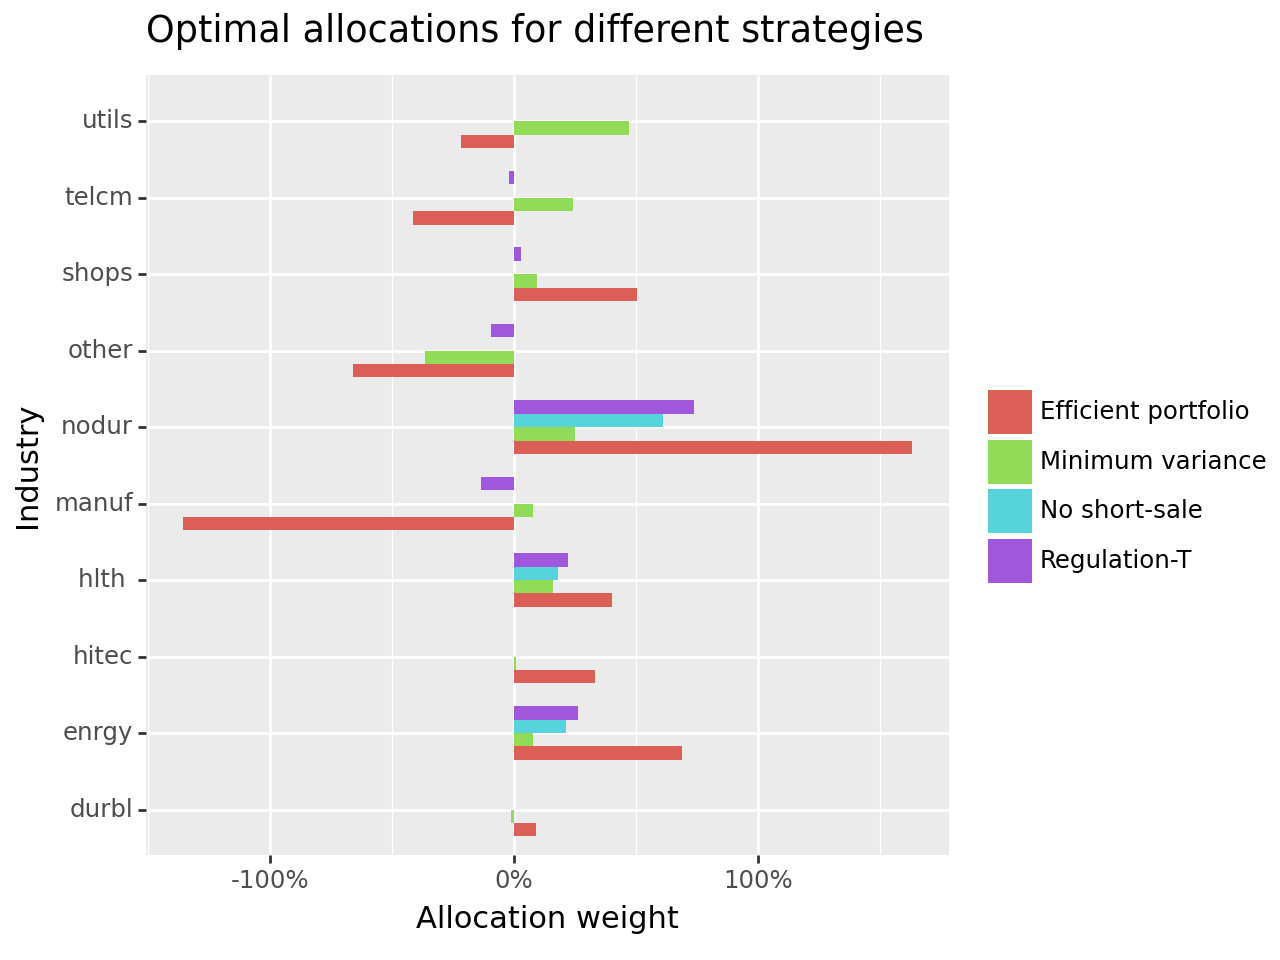

In [147]:
weights = (weights_mvp
  .merge(weights_efficient)
  .merge(weights_no_short_sale)
  .merge(weights_reg_t)
  .melt(id_vars="Industry", var_name="Strategy", value_name="weights")
)

weights_plot = (
  ggplot(weights,
         aes(x="Industry", y="weights", fill="Strategy")) +
  geom_bar(stat="identity", position="dodge", width=0.7) +
  coord_flip() +
  labs(y="Allocation weight", fill="",
       title="Optimal allocations for different strategies") +
  scale_y_continuous(labels=percent_format())
)
weights_plot.draw()

Final allocation strategy, which reflects a more realistic structure of transaction costs instead of the quadratic specification used above.
The function below computes efficient portfolio weights while adjusting for transaction costs of the form:
$\beta \sum_{i=1}^N |\omega_{i, t+1} - \omega_{i,t}^+|$ (L1 constraint)

In [150]:
#Final allocation strategy  which reflects a somewhat more realistic structure of transaction costs instead of the quadratic specification used above.
#No closed form solution 

def compute_efficient_weight_L1_TC(mu, sigma, gamma, beta, initial_weights):
    """Compute efficient portfolio weights with L1 constraint."""       
    
    def objective(w):
      return (gamma*0.5*w.T @ sigma @ w-(1+mu) @ w
               +(beta/10000)/2*np.sum(np.abs(w-initial_weights)))

    def gradient(w):
      return (-mu+gamma*sigma @ w 
              +(beta/10000)*0.5*np.sign(w-initial_weights))
      
    constraints = (
      {"type": "eq", "fun": equality_constraint, "jac": jacobian_equality}
    )
    
    result = minimize(
        x0=initial_weights,
        fun=objective,
        jac=gradient,
        constraints=constraints,
        tol=options["tol"],
        options={"maxiter": options["maxiter"]},
        method=options["method"]
    )
    
    return result.x

# Out of sample backtesting

We consider 120 periods from the past to update the parameter estimates before recomputing portfolio weights. Then, we update portfolio weights, which is costly and affects the performance. The portfolio weights determine the portfolio return. A period later, the current portfolio weights have changed and form the foundation for transaction costs incurred in the next period. Three different competing strategies:
- mean-variance efficient portfolio;
- mean-variance efficient portfolio with ex-ante adjustment for transaction costs;
- naive portfolio.

We also define two helper functions: One to adjust the weights due to returns and one for performance evaluation, where we compute realized returns net of transaction costs.

In [172]:
def adjust_weights(w, next_return):
    w_prev = 1+w*next_return
    return np.array(w_prev/np.sum(np.array(w_prev)))

def evaluate_performance(w, w_previous, next_return, beta=50):
    """Calculate portfolio evaluation measures."""  
    
    raw_return = np.dot(next_return, w)
    turnover = np.sum(np.abs(w-w_previous))
    net_return = raw_return-beta/10000*turnover
    
    return np.array([raw_return, turnover, net_return])

The following code chunk performs a rolling-window estimation, which we implement in a loop. 
- In each period, the estimation window contains the returns available up to the current period. Note that we use the sample variance-covariance matrix and ignore the estimation of $\hat \mu$
 entirely, but you might use more advanced estimators in practice.

In [184]:
industry_returns.iloc[p:(p+window_length-1), :].cov()

,nodur,durbl,manuf,enrgy,hitec,telcm,shops,hlth,utils,other
nodur,0.001480,0.001713,0.001456,0.001823,0.001233,0.001328,0.001236,0.000993,0.001010,0.001421
durbl,0.001713,0.008593,0.002926,0.003679,0.003483,0.001918,0.003089,0.002187,0.001239,0.003171
manuf,0.001456,0.002926,0.002321,0.002828,0.001971,0.001677,0.001769,0.001514,0.001052,0.002254
enrgy,0.001823,0.003679,0.002828,0.007603,0.002057,0.002346,0.001872,0.001646,0.001278,0.003160
hitec,0.001233,0.003483,0.001971,0.002057,0.002554,0.001478,0.001997,0.001527,0.000916,0.001998
telcm,0.001328,0.001918,0.001677,0.002346,0.001478,0.002078,0.001359,0.001236,0.000934,0.001765
shops,0.001236,0.003089,0.001769,0.001872,0.001997,0.001359,0.002152,0.001468,0.000939,0.001805
hlth,0.000993,0.002187,0.001514,0.001646,0.001527,0.001236,0.001468,0.001852,0.000741,0.001538
utils,0.001010,0.001239,0.001052,0.001278,0.000916,0.000934,0.000939,0.000741,0.001683,0.000911
other,0.001421,0.003171,0.002254,0.003160,0.001998,0.001765,0.001805,0.001538,0.000911,0.002580


In [176]:
for p in range(periods):
    returns_window = industry_returns.iloc[p:(p+window_length-1), :] #estimation span of 636 periods
    next_return = industry_returns.iloc[p+window_length, :]

    sigma_window = np.array(returns_window.cov())
    mu = 0*np.array(returns_window.mean()) #mean zero??

    # Transaction-cost adjusted portfolio
    w_1 = compute_efficient_weight_L1_TC(
      mu=mu, sigma=sigma_window, 
      beta=beta, 
      gamma=gamma, 
      initial_weights=w_prev_1 #naive weights #1/10 in this case
    )

    performance_values["MV (TC)"][p, :] = evaluate_performance(
      w_1, w_prev_1, next_return, beta=beta
    )
    w_prev_1 = adjust_weights(w_1, next_return)

    # Naive portfolio
    w_2 = np.ones(n_industries)/n_industries
    performance_values["Naive"][p, :] = evaluate_performance(
      w_2, w_prev_2, next_return
    )
    w_prev_2 = adjust_weights(w_2, next_return)

    # Mean-variance efficient portfolio (w/o transaction costs)
    w_3 = compute_efficient_weight(sigma=sigma_window, mu=mu, gamma=gamma)
    performance_values["MV"][p, :] = evaluate_performance(
      w_3, w_prev_3, next_return
    )
    w_prev_3 = adjust_weights(w_3, next_return)

In [187]:
pd.concat([performance, tmp_data], axis=0)

,raw_return,turnover,net_return,strategy
0,-0.068930,1.508849e-12,-0.068930,MV (TC)
1,0.060374,6.838419e-13,0.060374,MV (TC)
2,-0.002684,3.579081e-13,-0.002684,MV (TC)
3,-0.103137,9.183071e-13,-0.103137,MV (TC)
4,-0.062904,9.743456e-13,-0.062904,MV (TC)
...,...,...,...,...
631,-0.021864,1.436385e+00,-0.029046,MV
632,-0.082361,1.489769e+00,-0.089810,MV
633,0.079930,1.496013e+00,0.072450,MV
634,0.065435,1.785478e+00,0.056507,MV


In [186]:
performance = pd.DataFrame()
for i in enumerate(performance_values.keys()):
    tmp_data = pd.DataFrame(
      performance_values[i[1]], 
      columns=["raw_return", "turnover", "net_return"]
    )
    tmp_data["strategy"] = i[1]
    performance = pd.concat([performance, tmp_data], axis=0)

length_year = 12

performance_table = (performance
  .groupby("strategy")
  .aggregate(
    mean=("net_return", lambda x: length_year*100*x.mean()),
    sd=("net_return", lambda x: np.sqrt(length_year)*100*x.std()),
    sharpe_ratio=("net_return", lambda x: (
      (length_year*100*x.mean())/(np.sqrt(length_year)*100*x.std()) 
        if x.mean() > 0 else np.nan)
    ),
    turnover=("turnover", lambda x: 100*x.mean())
  )
  .reset_index()
)
performance_table.round(3)

,strategy,mean,sd,sharpe_ratio,turnover
0,MV,-0.896,12.571,NaN,211.095
1,MV (TC),11.853,15.189,0.780,0.000
2,Naive,11.832,15.191,0.779,0.234


Comment: The results clearly speak against mean-variance optimization. 
Turnover is huge when the investor only considers her portfolio’s expected return and variance. Effectively, the mean-variance portfolio generates a negative annualized return after adjusting for transaction costs.
 At the same time, the naive portfolio turns out to perform very well. In fact, the performance gains of the transaction-cost adjusted mean-variance portfolio are small. 
The out-of-sample Sharpe ratio is slightly higher than for the naive portfolio.
Note the extreme effect of turnover penalization on turnover: MV (TC) effectively resembles a buy-and-hold strategy which only updates the portfolio once the estimated parameters $\hat \mu_t$ and $\hat \Sigma_t$ indicate that the current allocation is too far away from the optimal theoretical portfolio.